# 0. Overview

- Objectives
  - The goal is to get an average score of +30 over 100 consecutive episodes.
- Applied algorithms
  - Deep Deterministic Policy Gradients(DDPG)
  - Shared Memory
  - Exploration: OUNoise

# 1. Setup the environment
- Solve second version environment with 20 agents
- Import required libraries
- Import network

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

from src.Agent import DDPGAgent

# 2.  Get the default brain

In [2]:
env = UnityEnvironment(file_name="Reacher_Windows_x86_64\Reacher.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


# 3. Set hyperparameters

In [3]:
ACTION_SIZE = 4
STATE_SIZE = 33

TRAINING_EPISODES = 1000

LR_ACTOR = 1e-4
LR_CRITIC = 3e-4

HIDDEN_UNITS = [512, 256]

GAMMA = 0.99
TAU = 1e-3

EVERY = 100

NUM_ACTORS = 20

EPSILON = 0.3
EPSILON_DECAY = 1e-6

MEMORY_SIZE = int(1e6)
BATCH_SIZE = 256

# 4. Train

Ep: 10	Average Score: 1.80	Max Score: 3.48
Ep: 20	Average Score: 5.51	Max Score: 15.26
Ep: 30	Average Score: 10.56	Max Score: 27.97
Ep: 40	Average Score: 16.04	Max Score: 35.65
Ep: 50	Average Score: 19.66	Max Score: 36.33
Ep: 60	Average Score: 22.20	Max Score: 36.33
Ep: 70	Average Score: 23.99	Max Score: 36.33
Ep: 80	Average Score: 25.33	Max Score: 36.87
Ep: 90	Average Score: 26.19	Max Score: 36.87
Ep: 100	Average Score: 26.91	Max Score: 36.87
Environment solved in 110 epsidoes!	Average Score: 30.26


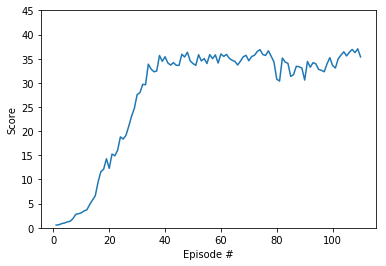

In [4]:
tf.reset_default_graph()

with tf.device("/device:GPU:0"):
    agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, NUM_ACTORS, EPSILON, TAU, EPSILON_DECAY)

save_file = 'model/p2_ddpg.ckpt'
saver = tf.train.Saver()
total_scores = []

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    agent.set_session(sess)
    
    agent.hard_update()

    for ep in range(TRAINING_EPISODES):    
        agent.reset()
        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        score = 0

        while True:
            action = agent.act(state, True)
            
            env_info = env.step(action)[brain_name]
            reward = env_info.rewards
            next_state = env_info.vector_observations
            done = env_info.local_done

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += sum(reward) / NUM_ACTORS
            
            if np.any(done):
                break
        
        total_scores.append(score)
        if ep > 0 and ep % 10 == 0:
            print("Ep: {}\tAverage Score: {:.2f}\tMax Score: {:.2f}".format(ep, np.mean(total_scores), np.max(total_scores)))

        if np.mean(total_scores[-100:]) > 30.0:
            print("Environment solved in {} epsidoes!\tAverage Score: {:.2f}".format(ep+1, np.mean(total_scores[-100:])))
            saver.save(sess, save_file)            
            break
        
fig = plt.figure()
fig.add_subplot(111)
plt.plot(np.arange(1, len(total_scores)+1), total_scores)
plt.ylim(0, 45)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()   

# 5. Validation

INFO:tensorflow:Restoring parameters from model/p2_ddpg.ckpt


Ep: 1, Score: 37.50, Average Score: 37.50
Ep: 2, Score: 37.72, Average Score: 37.61
Ep: 3, Score: 36.14, Average Score: 37.12
Ep: 4, Score: 35.97, Average Score: 36.83
Ep: 5, Score: 37.09, Average Score: 36.88
Ep: 6, Score: 38.09, Average Score: 37.09
Ep: 7, Score: 38.01, Average Score: 37.22
Ep: 8, Score: 35.78, Average Score: 37.04
Ep: 9, Score: 38.09, Average Score: 37.15
Ep: 10, Score: 37.71, Average Score: 37.21
Ep: 11, Score: 36.47, Average Score: 37.14
Ep: 12, Score: 36.87, Average Score: 37.12
Ep: 13, Score: 37.50, Average Score: 37.15
Ep: 14, Score: 37.40, Average Score: 37.17
Ep: 15, Score: 37.29, Average Score: 37.18
Ep: 16, Score: 36.24, Average Score: 37.12
Ep: 17, Score: 37.32, Average Score: 37.13
Ep: 18, Score: 36.70, Average Score: 37.11
Ep: 19, Score: 37.93, Average Score: 37.15
Ep: 20, Score: 36.89, Average Score: 37.14
Ep: 21, Score: 38.05, Average Score: 37.18
Ep: 22, Score: 37.63, Average Score: 37.20
Ep: 23, Score: 36.10, Average Score: 37.15
Ep: 24, Score: 36.41

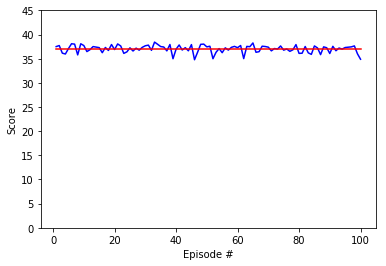

Total score (averaged over agents) this episode: 37.03


In [6]:
tf.reset_default_graph()

with tf.device("/device:GPU:0"):
    trained_agent = DDPGAgent(STATE_SIZE, ACTION_SIZE, 1234, HIDDEN_UNITS, LR_ACTOR, LR_CRITIC, BATCH_SIZE, GAMMA, MEMORY_SIZE, NUM_ACTORS, EPSILON, TAU, EPSILON_DECAY)

saver = tf.train.Saver()
total_scores = []
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    saver.restore(sess, save_file)
    trained_agent.set_session(sess)

    for ep in range(100):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations             
        score = 0                                        
        while True:
            action = trained_agent.act(state, False)
            env_info = env.step(action)[brain_name]      
            state = env_info.vector_observations         
            reward = env_info.rewards                         
            done = env_info.local_done                        
            score += sum(reward) / NUM_ACTORS                 
            if np.any(done):                                  
                break
        total_scores.append(score)
        print("Ep: {}, Score: {:.2f}".format(ep+1, score))
        
fig = plt.figure()
ax = fig.add_subplot(111)
x = range(1, len(total_scores)+1)
ax.plot(x, total_scores, color='blue')
ax.plot(x, np.ones_like(x) * np.mean(total_scores), color='red')

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.ylim(0, 40)
plt.show()   
print('Total score (averaged over agents) this episode: {:.2f}'.format(np.mean(total_scores)))

In [7]:
env.close()